## T-SNE Analysis

The purpose of this notebook is to run t-SNE on tags to analysis the relationship on character level, see if there is any pattern out there.

Unfortunately, I found this approach not so realiable,

- We lose the semantic of words when building embeding on character level
- t-SNE is too random

In [1]:
import sys
import os
import spacy
import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

sys.path.append('../../')

from canosp2020.tsne_utils import *
import chars2vec as c2v

Using TensorFlow backend.
/Users/michael/opt/anaconda3/envs/canosp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/michael/opt/anaconda3/envs/canosp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/michael/opt/anaconda3/envs/canosp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

### Ingest Data

Input CSV data is generated from the [./ticket_to_csv.py](./ticket_to_csv.py) script.

We are using all machine-generated and hand-annoatated tags to generate a t-distributed Stochastic Neighbor Embedding (t-SNE) model to discover the relationship between variety of tags. For more background information, please refer to [github.com/mlopatka/CANOSP2020/issues/59](https://github.com/mlopatka/CANOSP2020/issues/59)

#### How?

- Download `tickets.json` and `tickets.csv` from `SUMO_data_dump_raw` folder at our share GDrive folder



**Remember that jupyter requires filesystem paths specified RELATIVE to the path from which jupyter was launched**

- What subset of the available corpus is used?
- What are the criteria defined for measuring performance?
- Is filtering on date, version, tags employed? No
- Size of the data being used in this demo. 

In [2]:
"""code executing the data ingestions steps"""
# fetch all machine-generated and hand-annoatated tags
# tags = get_tags("../../data/tickets.csv")
from canosp2020.preprocessing import Preprocess

# # load pre-trained char2vec model
c2v_model = c2v.load_model("train_fr_150/")
regular_tags, mturk_tags = get_tags_both_human_and_mturk("../../data/all_annotated_tickets.csv")
clean_regular_tags = Preprocess.preprocess_tags(regular_tags)
clean_mturk_tags = Preprocess.preprocess_tags(mturk_tags)

Instructions for updating:
Colocations handled automatically by placer.
Model and weights loaded successfully train_fr_150/


In [3]:
print(len(regular_tags))
print(len(mturk_tags))
print(len(clean_regular_tags))
print(len(clean_mturk_tags))

1295355
33277
1214771
30661


### Preprocessing and Feature Engineering steps

- Remove tags that occurs less than a specific <threshold> time. See `Config` class.
- Remove tags using a series of filter function.

In [4]:
class Config(object):
    """
    Customize config to run the T-SNE model
    """
    def __init__(self):
        self.threshold = 0.002 # The top 20 percentile of tags (occurences) will be removed
        self.tsne_n_iter = 2500 # See https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
        self.tsne_perplexity = 40 # See https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

config_01 = Config()

In this step, we twick the parameters

- threshold
- number of iteration to train the model

Until we see a reasonable distrubition of the tags. However, this step is not realiable since we there is too much randomness involved in t-SNE.

# of tags: 30661, # of filter tags: 23910
# of unique tags: 3900, # of unique filtered tags 466
Reference dict: 'Label': 'Tag'
{0: 'firefox', 1: 'bookmark', 2: 'error', 3: 'update', 4: 'tab', 5: 'browser', 6: 'password', 7: 'windows', 8: 'crash', 9: 'website', 10: 'setting', 11: 'login', 12: 'account', 13: 'page', 14: 'sync', 15: 'version', 16: 'delete', 17: 'save', 18: 'change', 19: 'site', 20: 'open', 21: 'email', 22: 'search', 23: 'not', 24: 'bar', 25: 'download', 26: 'file', 27: 'restore', 28: 'video', 29: 'block'}


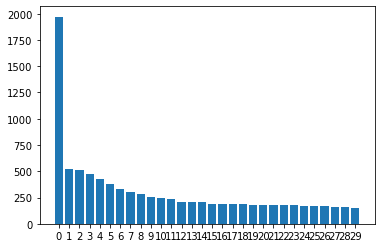

Word embedding shape: (466, 150)
T-SNE embedding shape: (466, 2)


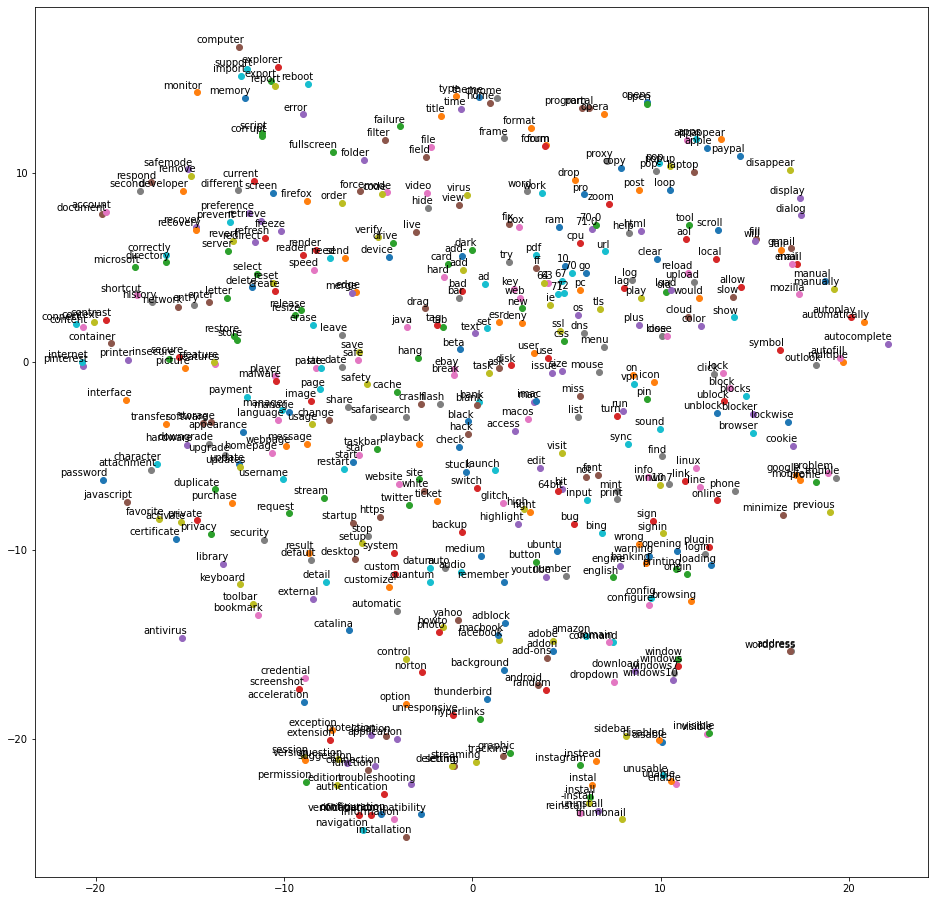

In [30]:
"""code performing data cleaning and data preprocessing tasks"""
import csv
import itertools
import matplotlib.pyplot as plt
import re

from sklearn.manifold import TSNE
from collections import Counter
# from tsne_utils import build_tsne_embeddings, plot_tsne, cleanup_tags

tags = clean_mturk_tags
unique_filtered_tags = cleanup_tags(tags, threshold=0, occ_threshold=10)
# preplexity: we should experiment with value between 5 and 50 to see different results
# n_components: the input word embeding is a (num_words, 150) 2-D matrix
# n_iter: number of iterations for optimization, >= 250
# random_state: seed for random number generator
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
tsne_embeddings = build_tsne_embeddings(unique_filtered_tags, c2v_model=c2v_model, tsne_model=tsne_model)
plot_tsne(tsne_embeddings, unique_filtered_tags)

## K-Mean clustering on t-sne embeding

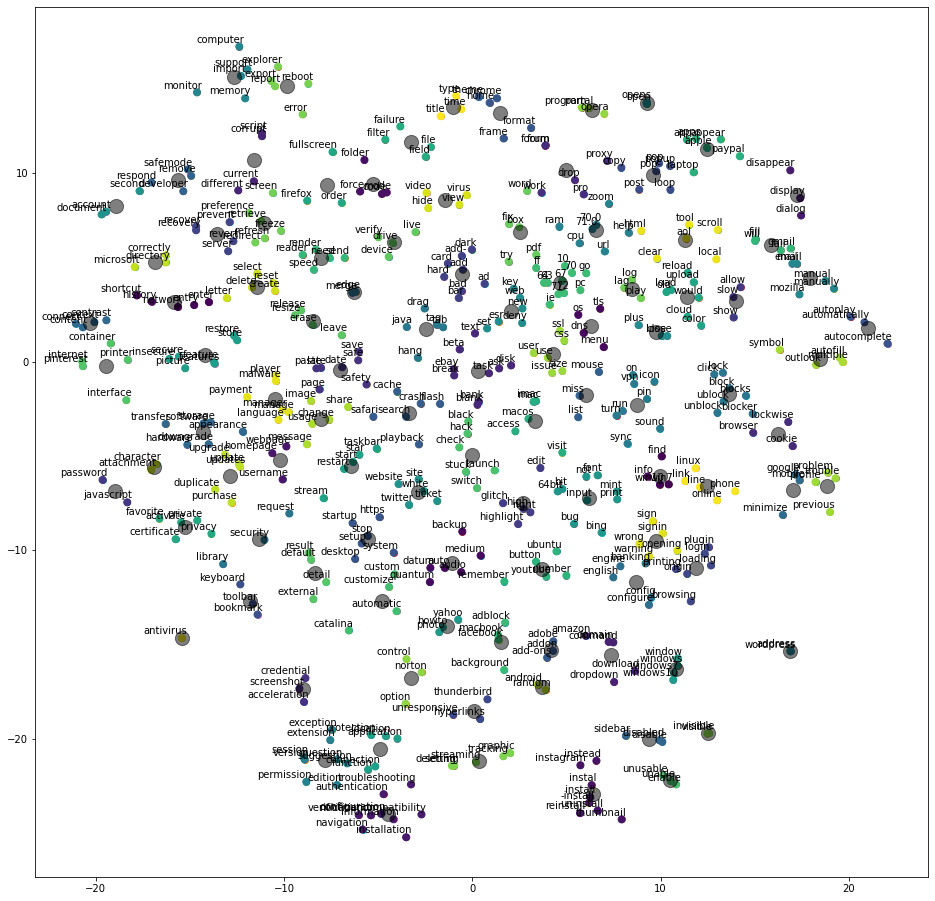

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(random_state=0, n_clusters=100).fit(tsne_embeddings)
kmeans.labels_

predicted_embeddings = kmeans.predict(tsne_embeddings)

plt.figure(figsize=(16, 16))
for pred, actual, label in zip(predicted_embeddings, tsne_embeddings, unique_filtered_tags):
    x = actual[0]
    y = actual[1]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")

plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=predicted_embeddings, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [32]:
import csv

with open("../../candidate_tags/t-sne.csv", "w") as output_tags_f:
    writer = csv.writer(output_tags_f)
    writer.writerows([[each] for each in unique_filtered_tags])

# of tags: 1214771, # of filter tags: 535424
# of unique tags: 4873, # of unique filtered tags 355
Reference dict: 'Label': 'Tag'
{0: 'firefox-40', 1: 'firefox-50', 2: 'firefox-401', 3: 'privacy--security_1', 4: 'datum', 5: 'windows-81', 6: 'download--install_1', 7: 'mac-os', 8: 'firefox-60', 9: 'firefox-36', 10: 'features', 11: 'linux', 12: 'bookmark', 13: 'mac-os-x-106', 14: 'firefox-80', 15: 'firefox-70', 16: 'beta', 17: 'crash', 18: 'firefox-701', 19: 'addon', 20: 'tab', 21: 'needsinfo', 22: 'escalate', 23: 'firefox-602', 24: 'sync', 25: 'learning', 26: 'firefox-290', 27: 'firefox-90', 28: 'firefox-100', 29: 'firefox-380'}


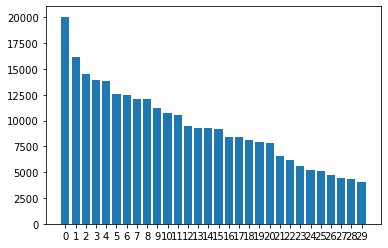

Word embedding shape: (355, 150)
T-SNE embedding shape: (355, 2)


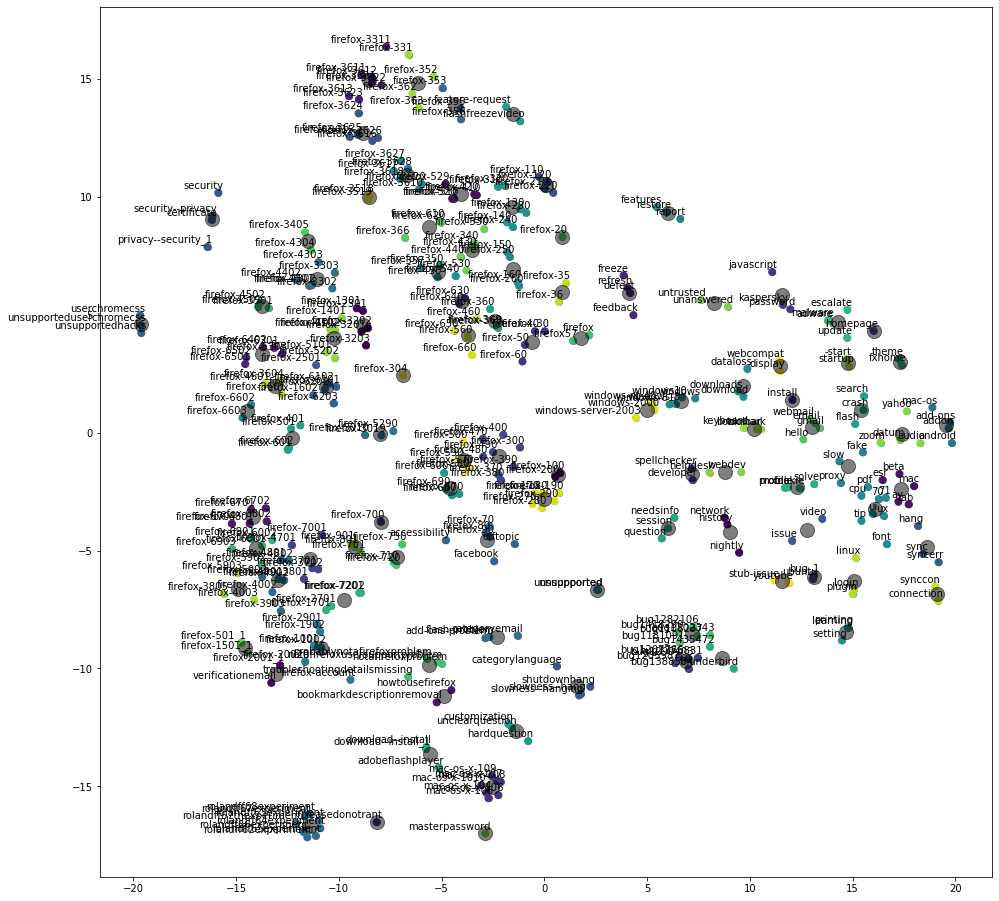

In [26]:
tags = clean_regular_tags
unique_filtered_tags = cleanup_tags(tags, threshold=config_01.threshold, occ_threshold=50)
# preplexity: we should experiment with value between 5 and 50 to see different results
# n_components: the input word embeding is a (num_words, 150) 2-D matrix
# n_iter: number of iterations for optimization, >= 250
# random_state: seed for random number generator
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_embeddings = build_tsne_embeddings(unique_filtered_tags, c2v_model=c2v_model, tsne_model=tsne_model)
# plot_tsne(tsne_embeddings, unique_filtered_tags)

kmeans = KMeans(random_state=0, n_clusters=100).fit(tsne_embeddings)
kmeans.labels_

predicted_embeddings = kmeans.predict(tsne_embeddings)

plt.figure(figsize=(16, 16))
for pred, actual, label in zip(predicted_embeddings, tsne_embeddings, unique_filtered_tags):
    x = actual[0]
    y = actual[1]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")

plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=predicted_embeddings, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

## t-SNE on ticket question

Okay, it didn't work out since without GPU t-sne takes forever to run on the entire corpus.

In [5]:
# TITLE_CONTENT = "title_content"
# REGULAR_TAGS = "regular_tags"
# MTURK_TAGS = "mturk_tags"

# df = pd.read_csv("../../data/all_annotated_tickets.csv")
# df[REGULAR_TAGS] = df.iloc[:, 3:13].astype(str).agg('|'.join, axis=1)
# df[MTURK_TAGS] = df.iloc[:, 13:].astype(str).agg('|'.join, axis=1)

/Users/michael/opt/anaconda3/envs/canosp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246

In [6]:
# df[TITLE_CONTENT] = df["title"] + " " + df["content"]
# df[TITLE_CONTENT].replace("", np.nan, inplace=True)
# df.dropna(subset=[TITLE_CONTENT], inplace=True)

In [7]:
# nlp = spacy.load("en_core_web_sm")
# docs = list(nlp.pipe(df["title_content"], disable=["tagger", "parser", "ner"]))

In [8]:
# docs_mturk_tagged = 
# docs_mturk_tagged = list(map(lambda doc, tags: TaggedDocument(words=[t.text for t in doc], tags=[t for t in tags.split("|") if t != 'nan']), docs, df[MTURK_TAGS]))
# zip(docs, df[MTURK_TAGS]).apply(lambda x: TaggedDocument(words=[t for t in x[0]], tags=x[1].split("|")))
# docs_mturk_tagged = list(map(lambda doc, i: TaggedDocument(words=[t.text for t in doc], tags=[str(i)]), docs, df["id"]))

In [3]:
# import multiprocessing
# doc2vec_model = Doc2Vec.load("mturk_doc2vec.genism.model") #Doc2Vec(vector_size=100, min_count=2, workers=multiprocessing.cpu_count(), epochs=10)

In [9]:
# doc2vec_model.build_vocab(docs_mturk_tagged)
# doc2vec_model.train(docs_mturk_tagged, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
# doc2vec_model.save('mturk_doc2vec.genism.model')
# doc2vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [4]:
# x_train = np.array([doc2vec_model.docvecs.vectors_docs[i] for i in range(len(mturk_train))])
# print(doc2vec_model.infer_vector(mturk_train[0].words))
# doc2vec_model.train(mturk_train, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
# print(len(mturk_train))
# print(doc2vec_model.wv.most_similar('bookmark'))
# print(len(doc2vec_model.docvecs.vectors_docs))

[('bookmarks', 0.8056915998458862), ('Bookmarks', 0.7660006284713745), ('Bookmark', 0.763748824596405), ('bookmarked', 0.6678995490074158), ('tab', 0.6601133942604065), ('favorites', 0.6590414643287659), ('dropdown', 0.647312343120575), ('history', 0.6196302771568298), ('them', 0.6170406341552734), ('folder', 0.6150453090667725)]


In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# doc_tags = doc2vec_model.docvecs.doctags.keys()
# X = doc2vec_model[doc_tags]
# tsne_model = TSNE(n_components=2, n_jobs=multiprocessing.cpu_count())
# X_tsne = tsne_model.fit_transform(X)

In [125]:
# df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
# # plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
# # plt.show()
# doc2vec_model.wv.most_similar("boomark")

[('nav', 0.5887632369995117),
 ('navagation', 0.5835541486740112),
 ('quicklaunch', 0.5782846212387085),
 ('sarch', 0.543064534664154),
 ('commad', 0.543022096157074),
 ('tast', 0.5390629768371582),
 ('verticle', 0.5179694294929504),
 ('baz', 0.5103129744529724),
 ('favotites', 0.5084972977638245),
 ('quickstart', 0.5061242580413818)]

### Tag lexicon definition description

Define the set of tags that are defined for the task

In [34]:
"""code that performes the tag selection and/or any data manipulation that prefaces the classification/annotation task"""

Word embedding shape: (359, 150)


### Classifier/Annontator Training step

Describe the model and the model training step

- Include a description the feature space used
- Include a description of the selected classification or annotation model
- Describe the training process and expected runtime for training

In [8]:
"""code that executes model training step"""

'code that executes model training step'

### Classifier/Annotator Testing step

Describe the testing of the trained model's performace against a defined test set.

- Include the raw performance
- Include the source of ground truth for the evaluation
- Include figures for FP/FN/ROC type metrics describing the model performance.

In [9]:
"""code that executes the model testing step"""

'code that executes the model testing step'

### Interpretation
Sumamrize the model performance and findings related to specific misclassified items also a breif description of the findings as they correpsonde to generalizability.